# John Vincent Deniega
# ADS 509 - Fall 2024
# 23 September 2024

# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Use this space for any additional import statements you need
import string

In [3]:
# Place any additional functions or constants you need here.

# Find the union of all words that appear in all four corpora
def filter_token_min_count(counts, n):
    common_tokens = set(counts['cher_lyrics'].keys()) & \
                    set(counts['robyn_lyrics'].keys()) & \
                    set(counts['cher_tweets'].keys()) & \
                    set(counts['robyn_tweets'].keys())
    # Filter for words that don't appear at least n times
    filtered_tokens = {token for token in common_tokens if
                       all(counts[corpus].get(token, 0) >= n for corpus in counts)}
    return filtered_tokens

# Compute ratio of appearances for each token in each corpus in 1 vs all comparison
def compute_ratios(counts, filtered_tokens):
    ratios = {}
    # Token count in each corpus
    total_tokens = {corpus: sum(counts[corpus].values()) for corpus in counts}
    for corpus in counts:
        ratios[corpus] = {}
        for token in filtered_tokens:
            # This corpus
            count_in_corpus = counts[corpus].get(token, 0) # Explicit count
            concentration_in_corpus = count_in_corpus / total_tokens[corpus] # Concentration
            # The other corpora - Grab the sum of the three remaining documents
            count_in_other = sum(counts[other_corpus].get(token, 0)
                                 for other_corpus in counts if other_corpus != corpus)
            total_in_other = sum(total_tokens[other_corpus]
                                 for other_corpus in counts if other_corpus != corpus)
            if total_in_other > 0: # Check for possible division by zero
                concentration_in_other = count_in_other / total_in_other
                ratios[corpus][token] = concentration_in_corpus / concentration_in_other
            else: # Handle division by zero
                ratios[corpus][token] = float('inf')  # Handle division by zero
    return ratios

# Grab the top 10 tokens with their highest calculated ratios for each corpus
def top_tokens_ratio(token_ratios, top_n=10):
    top_tokens = {}
    for corpus, corpus_ratios in token_ratios.items(): # Iterate each corpus's tokens
        # Sort tokens by ratio (x[1]) in descending order (highest ratio first)
        sorted_tokens = sorted(corpus_ratios.items(), key=lambda x: x[1], reverse=True)
        # Subset the top 10 tokens by ratio (works because we sorted before this step)
        top_tokens[corpus] = sorted_tokens[:top_n]
    return top_tokens

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")
stopwords = set(sw)

# JDD. Applying directly from BTAP's Ch 1 "First_Insights.ipynb", as instructed

include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
# From Deniega (2024) Assignment 2.1 solution with modifications
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    avg_token_length = num_characters / num_tokens

    most_common_tokens = Counter(tokens).most_common(num_tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print(f"There are an avg of {avg_token_length:.3f} characters per token.")
           
        print(f"The five most common tokens are:") # print the five most common tokens 
        for token, count in most_common_tokens[:5]:
            print(f"{token}: {count}")
        print("\n")
    return({'tokens': num_tokens, 
            'num_unique_tokens': num_unique_tokens,
            'num_characters': num_characters,
            'lexical_diversity': lexical_diversity,
            'avg_token_length': avg_token_length})
    
    #return(0) # Commenting out since my solution returns as above
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

def remove_stop(tokens) :
    return [word for word in tokens if word.lower() not in stopwords]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    tokens = text.split()
    return(tokens)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

# Template from my submission from Deniega (2024), ADS509 Module 2.1 Assignment
data_location = os.path.expanduser("~/Desktop/usd_ADS/github/ads509-mod3/M1_Results/")
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

## Parse ingested data into lyrics

Reference

Deniega, J. D. (2024, September 15). ADS 509 assignment 2.1: Tokenization, normalization, descriptive statistics. University of San Diego. https://github.com/vanguardfox/ads509-mod2/blob/main/Deniega_ADS509_A2.ipynb

In [7]:
# Read in the lyrics data as a data frame with artist and song as multi-index and lyrics as the value
lyrics_path = os.path.join(data_location, lyrics_folder)
data = []
punctuation = string.punctuation + "'" # adding because it is one of the top tokens
sans_punct = str.maketrans('', '', string.punctuation) # Clean punctuation
for artist_folder in os.listdir(lyrics_path):
    artist_path = os.path.join(lyrics_path, artist_folder)
    if os.path.isdir(artist_path):
        for filename in os.listdir(artist_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(artist_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    lines = content.split('\n')
                    song_title = lines[0].strip('"') # Title in quotations
                    lyrics = ' '.join(lines[4:]).strip() # Lyrics start on line 4
                    data.append([artist_folder, song_title, lyrics])
df = pd.DataFrame(data, columns=['artist', 'song', 'lyrics'])
df.set_index(['artist', 'song'], inplace=True)


### Verify data ingested correctly

In [8]:
lyrics_data = df
lyrics_data.head()

lyrics
artist song                                                             
robyn  Include Me Out  It is really very simple Just a single pulse, ...
       Electric        Electric...  It's electric It's a natural high...
       Beach 2K20      (So you wanna go out? How you gonna get there?...
       Love Kills      If you're looking for love Get a heart made of...
       Time Machine    Hey, what did I do? Can't believe the fit I ju...

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [9]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


### Verify output

In [10]:
lyrics_data.head()

lyrics  \
artist song                                                                
robyn  Include Me Out  It is really very simple Just a single pulse, ...   
       Electric        Electric...  It's electric It's a natural high...   
       Beach 2K20      (So you wanna go out? How you gonna get there?...   
       Love Kills      If you're looking for love Get a heart made of...   
       Time Machine    Hey, what did I do? Can't believe the fit I ju...   

                                                                  tokens  \
artist song                                                                
robyn  Include Me Out  [really, simple, single, pulse, repeated, regu...   
       Electric        [electric, electric, natural, high, electric, ...   
       Beach 2K20      [wanna, go, gonna, get, ok, call, someone, alr...   
       Love Kills      [youre, looking, love, get, heart, made, steel...   
       Time Machine    [hey, cant, believe, fit, threw, stupid, wante...   

                       num_tokens  
artist song                        
robyn  Include Me Out         233  
       Electric               152  
       Beach 2K20             172  
       Love Kills             244  
       Time Machine           126

In [11]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
389654,cher,10 yrs RBKA🥰,"[10, yrs, rbka🥰]"
2481609,cher,#russianroulette2 local artist for booking con...,"[#russianroulette2, local, artist, booking, co..."
763640,cher,No Happy Endings is an anthology of twisted fi...,"[happy, endings, anthology, twisted, fiction🗞️..."
2776169,cher,hai ✌ my name is azia. i love to write stories...,"[hai, ✌, name, azia, love, write, stories, sin..."
834555,cher,Howdy • TAMU'23 • she/her • BLM • TPWK • ghost...,"[howdy, •, tamu23, •, sheher, •, blm, •, tpwk,..."
251455,cher,💯❤Ohana💯❤Loyalty💯❤Love,[💯❤ohana💯❤loyalty💯❤love]
2036505,cher,Passion.Purpose.Family.Friends.Art.Music.MyLif...,"[passionpurposefamilyfriendsartmusicmylife, ⚓️]"
512187,cher,❤🌵,[❤🌵]
616381,cher,• Student nurse (Second year) • Interest in Mo...,"[•, student, nurse, second, year, •, interest,..."
3065170,cher,I love horror & reality TV. I was almost born ...,"[love, horror, reality, tv, almost, born, hall..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I could improve on tokenization by having each token parsed by character to separately identify and tokenize any emojis that are in the same string object not broken by whitespace. This would help "pull" the emoji out from a token.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [13]:
# your code here
# Use descriptive_stats grouped by artist (or verbose=False if only need the statistics)
stats = lyrics_data.groupby("artist").apply(lambda x: descriptive_stats(x["tokens"].sum(), verbose=True))
stats

There are 35104 tokens in the data.
There are 3682 unique tokens in the data.
There are 168661 characters in the data.
The lexical diversity is 0.105 in the data.
There are an avg of 4.805 characters per token.
The five most common tokens are:
love: 966
im: 511
know: 480
dont: 430
youre: 332


There are 15000 tokens in the data.
There are 2137 unique tokens in the data.
There are 72601 characters in the data.
The lexical diversity is 0.142 in the data.
There are an avg of 4.840 characters per token.
The five most common tokens are:
know: 305
im: 299
dont: 297
love: 269
got: 249




artist
cher     {'tokens': 35104, 'num_unique_tokens': 3682, '...
robyn    {'tokens': 15000, 'num_unique_tokens': 2137, '...
dtype: object

Q: what observations do you make about these data? 

A: The tokens 'love', 'im', 'know', and 'dont' appear to be in common as most frequent tokens, which may be a feature of the genre they are a part of. Robyn has more lexical diversity than Cher, which suggests fewer refrains of lyrics.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [14]:
# your code here
n = 5

# Put each corpora's tokens in its own variable
cher_lyrics = lyrics_data.loc["cher"].tokens
robyn_lyrics = lyrics_data.loc["robyn"].tokens
cher_tweets = twitter_data[twitter_data.artist == "cher"]['tokens']
robyn_tweets = twitter_data[twitter_data.artist == "robyn"]['tokens']

# Combine each line in {artist}_lyrics into a single list object
cher_lyrics = [item for sublist in cher_lyrics for item in sublist]
robyn_lyrics = [item for sublist in robyn_lyrics for item in sublist]

# Combine each line in {artist}_tweets into a single list object
cher_tweets = [item for sublist in cher_tweets for item in sublist]
robyn_tweets = [item for sublist in robyn_tweets for item in sublist]

# Put each corpus word count in its own variable
cher_lyrics_count = Counter(cher_lyrics)
robyn_lyrics_count = Counter(robyn_lyrics)
cher_tweets_count = Counter(cher_tweets)
robyn_tweets_count = Counter(robyn_tweets)

# Use a dictionary to store results in a single object
counts = {
    'cher_lyrics': cher_lyrics_count,
    'robyn_lyrics': robyn_lyrics_count,
    'cher_tweets': cher_tweets_count,
    'robyn_tweets': robyn_tweets_count
}

In [15]:
# Filter for >= 5 count, compute ratios, and identify top tokens
filtered_tokens = filter_token_min_count(counts, n)
token_ratios = compute_ratios(counts, filtered_tokens)
top_tokens = top_tokens_ratio(token_ratios)

### Display results

In [16]:
for corpus, top_tokens in top_tokens_ratio(token_ratios).items():
    print(f"Top 10 tokens for {corpus}:")
    for token, ratio in top_tokens:
        print(f"{token}: {ratio:.2f}")
    print() # Adding extra line for readability

Top 10 tokens for cher_lyrics:
ooh: 240.99
chorus: 185.48
knock: 77.97
tonight: 67.21
ohh: 55.49
ooo: 54.12
tears: 50.10
gonna: 32.67
deny: 31.67
gotta: 31.32

Top 10 tokens for robyn_lyrics:
chorus: 405.95
ooo: 126.79
ohh: 118.17
beat: 102.61
88: 94.68
ooh: 91.08
deny: 84.07
itll: 77.23
alright: 59.50
crash: 58.93

Top 10 tokens for cher_tweets:
god: 2.61
proud: 2.46
faith: 2.20
friend: 2.16
woman: 2.14
truth: 2.03
stand: 1.91
boys: 1.78
two: 1.74
mama: 1.74

Top 10 tokens for robyn_tweets:
till: 6.95
til: 4.25
sound: 2.70
men: 2.54
spinning: 2.30
music: 1.82
88: 1.69
head: 1.66
dance: 1.63
crash: 1.61



Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The word "chorus" appears at an unexpected higher frequency within lyrics. This may be a remaining artifact when tokenizing the lyrics where this descriptive word is more likely a tag for the actual chorus rather than an actual lyric. This must be handled as an actual stop word for lyrics in a future iteration. Additionally, the ratios of the lyrics for the top words are orders of magnitude larger than those of the tweets. This suggests that songwriters tend to use a narrower set of words relative to the set of words typical to internet users. Finally, interjection-type words like "ooh" and "ooo" are much more prevalent in lyrics than in Twitter descriptions. This is expected since the lyrics are a direct transcription and tokenization of the sounds a singer makes, which is unlikely to be used in regular internet posts to the same degree.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [17]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Reference

"First_Insights.ipynb" [Lecture Notes]. University of San Diego. 
https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

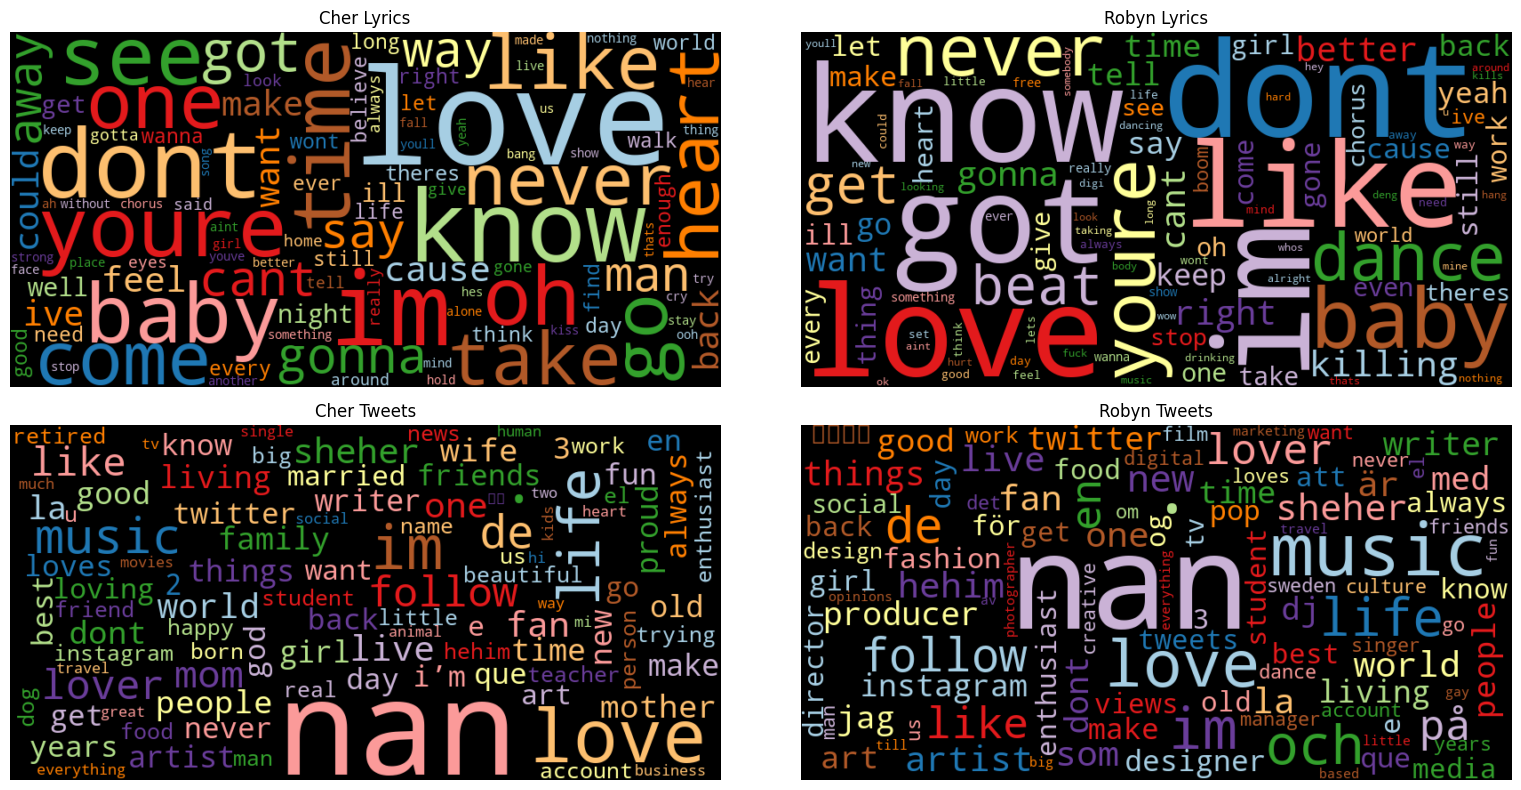

In [18]:
freq_cher_lyrics = count_words(lyrics_data.loc['cher'], column ='tokens')
freq_robyn_lyrics = count_words(lyrics_data.loc['robyn'], column ='tokens')
freq_cher_tweets = count_words(twitter_data[twitter_data.artist == "cher"], column ='tokens')
freq_robyn_tweets = count_words(twitter_data[twitter_data.artist == "robyn"], column ='tokens')

plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
wordcloud(freq_cher_lyrics['freq'], title='Cher Lyrics', max_words=100)
plt.subplot(2, 2, 2)
wordcloud(freq_robyn_lyrics['freq'], title='Robyn Lyrics', max_words=100)
plt.subplot(2, 2, 3)
wordcloud(freq_cher_tweets['freq'], title='Cher Tweets', max_words=100)
plt.subplot(2, 2, 4)
wordcloud(freq_robyn_tweets['freq'], title='Robyn Tweets', max_words=100)
plt.tight_layout()
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: As expected, love songs tend to dominate in lyrics with similar tokens. It also appears that the token "nan" appears in tweets quite often, which I surmise that it is a placeholder likely for emojis that are unable to be interpreted by the wordcloud package. It appears that lyrics are more similar to each other of the same type rather than within the same artist.